In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# train_data1 = pd.read_csv("D:\\Personal\\Msc\\Y1S1\\Advanced Data Mining\\GroupAssignment\\web-traffic-time-series-forecasting\\TrainingData\\train_1.csv").fillna(0)
train_data2 = pd.read_csv("D:\\Personal\\Msc\\Y1S1\\Advanced Data Mining\\GroupAssignment\\web-traffic-time-series-forecasting\\TrainingData\\train_2.csv").fillna(0)

In [3]:
train_data2.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [4]:
train_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


Get the language of a given page

In [6]:
import re # to separate pages based on language (regular expression)

def find_language(url):
    res = re.search('[a-z][a-z].wikipedia.org',url)
    if res:
        return res[0][0:2]
    return 'na'

train_data2['lang'] = train_data2.Page.map(find_language)

Separate all the pages based on their language and average them up to find views per page per language

In [7]:
lang_sets = {}
lang_sets['en'] = train_data2[train_data2.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train_data2[train_data2.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train_data2[train_data2.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train_data2[train_data2.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train_data2[train_data2.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train_data2[train_data2.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train_data2[train_data2.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train_data2[train_data2.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

Plots of average number of views for all different languages per day

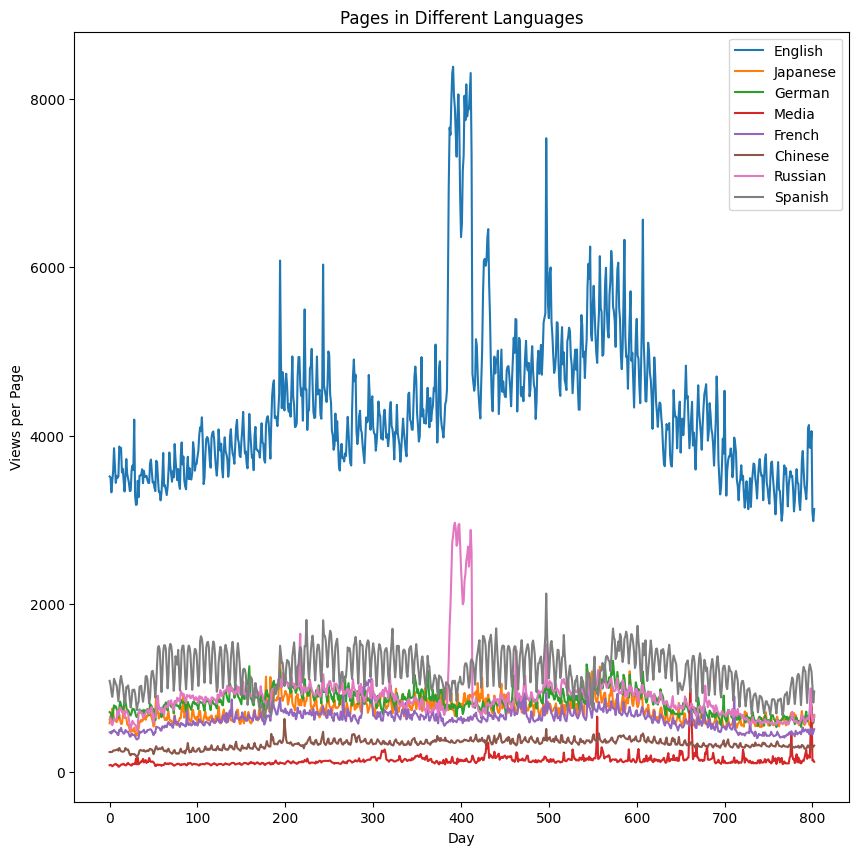

In [8]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

Plot Autocorrelation and Partial Autocorrelation graphs for all these languages, to estimate the hyperparameters used in training the ARIMA model.

en


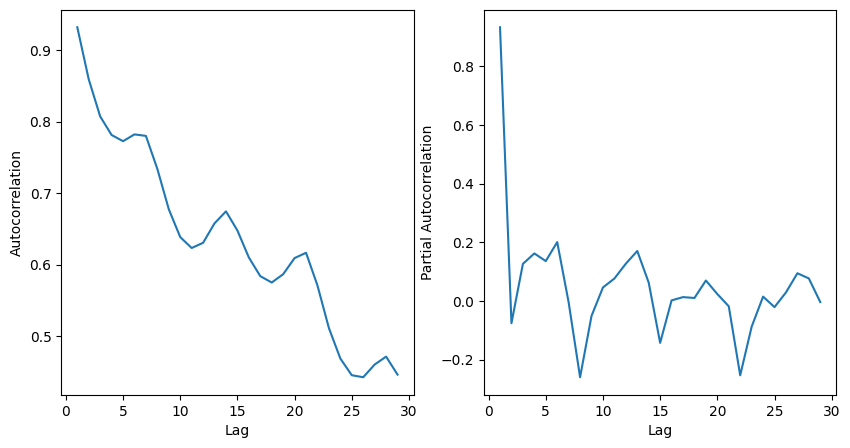

ja


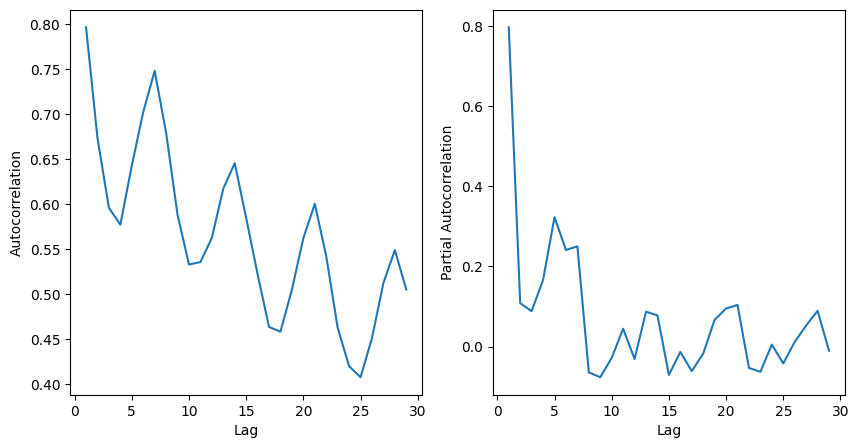

de


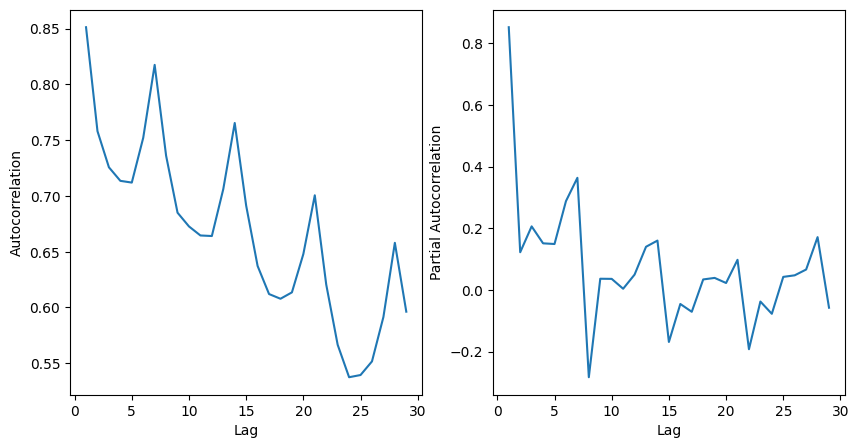

na


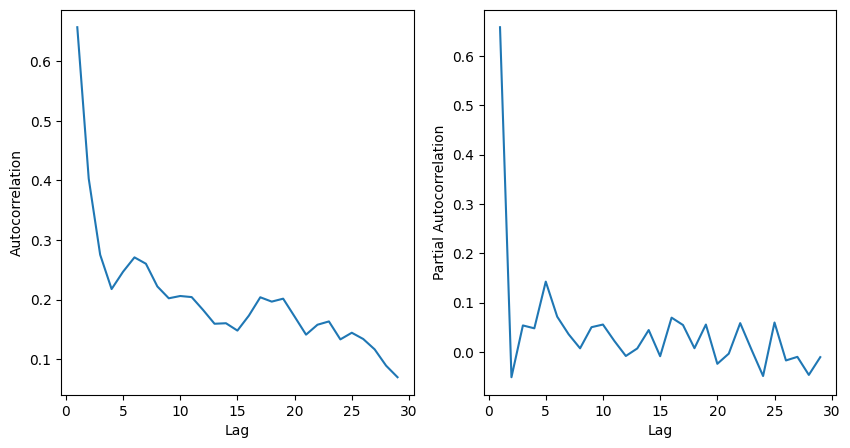

fr


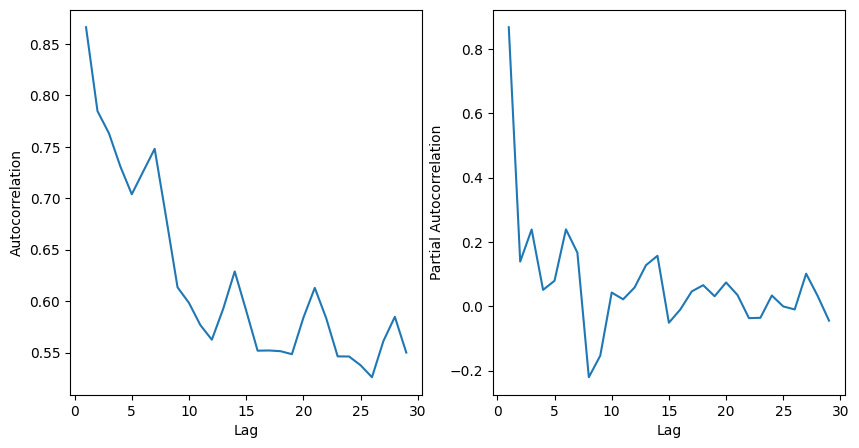

zh


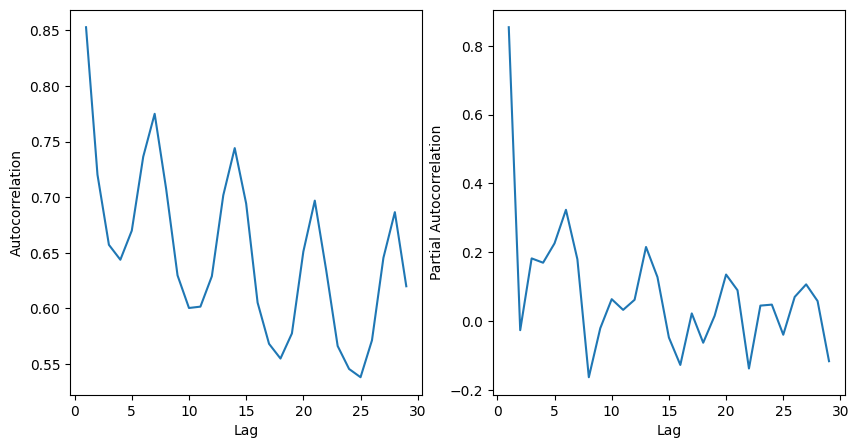

ru


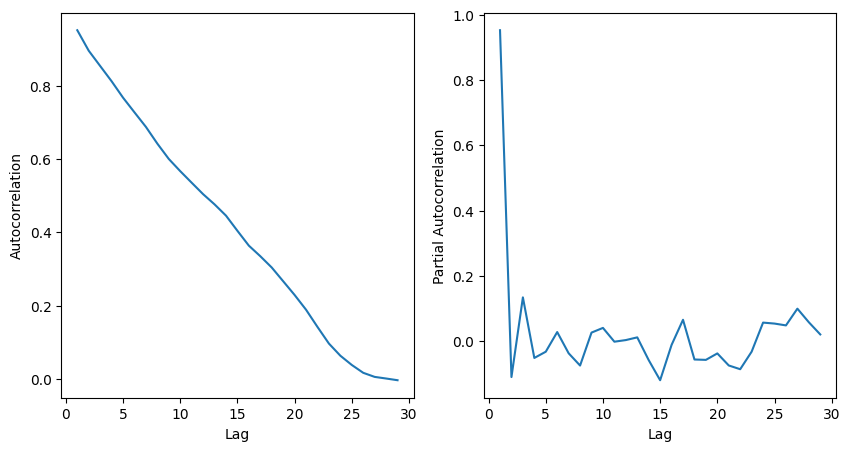

es


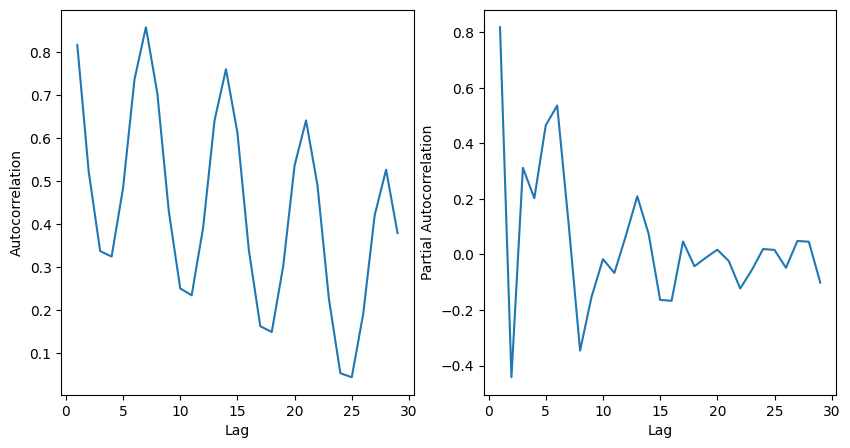

In [11]:
from statsmodels.tsa.arima_model import ARIMA # to make an ARIMA model that fits the data
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

for key in sums:
    fig = plt.figure(1,figsize=[10,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    data = np.array(sums[key])
    autocorr = acf(data)
    pac = pacf(data)

    x = [x for x in range(len(pac))]
    ax1.plot(x[1:],autocorr[1:])

    ax2.plot(x[1:],pac[1:])
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')

    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Partial Autocorrelation')
    print(key)
    plt.show()

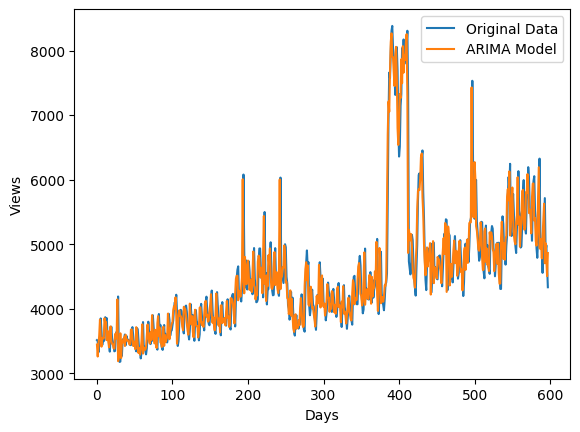

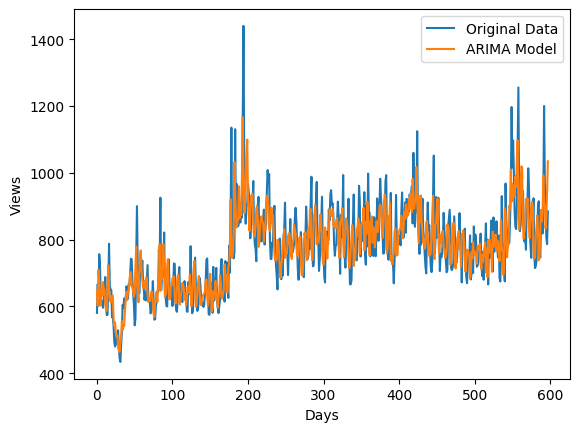

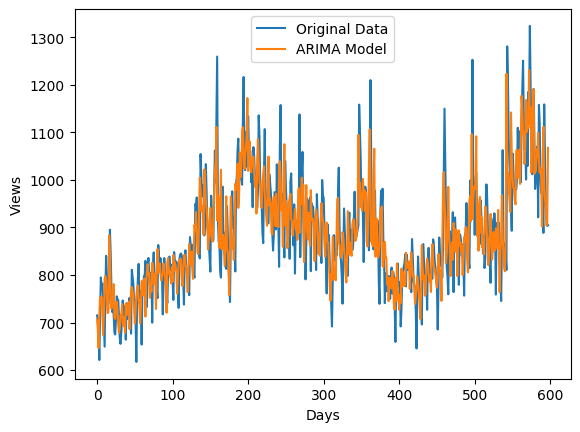

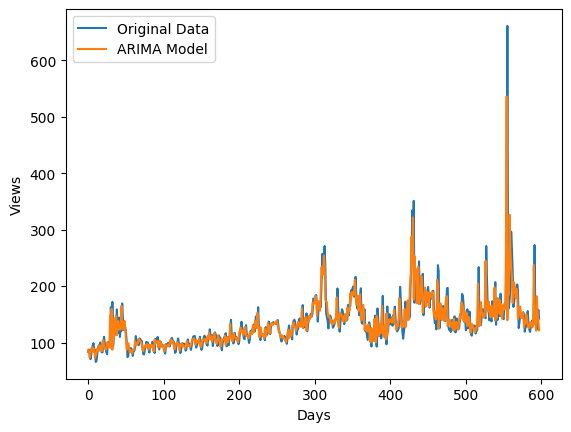

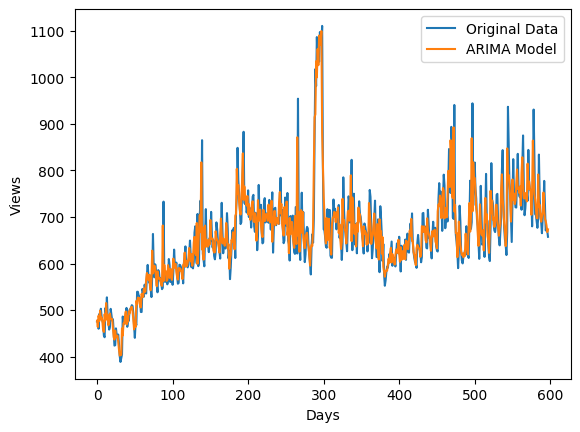

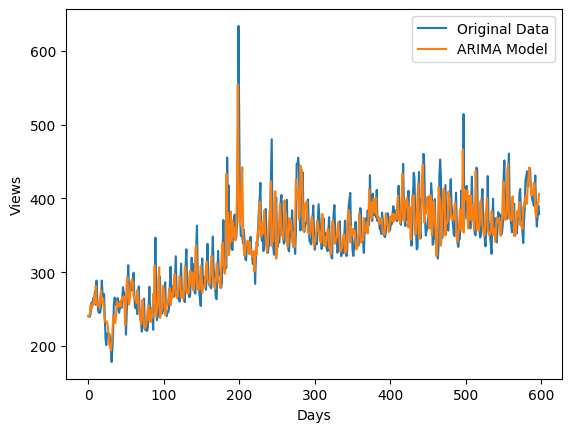

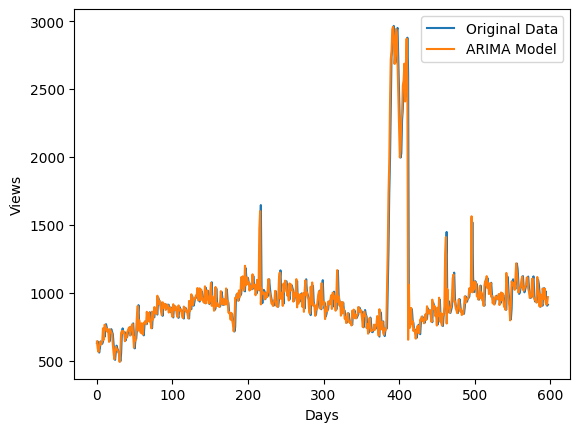

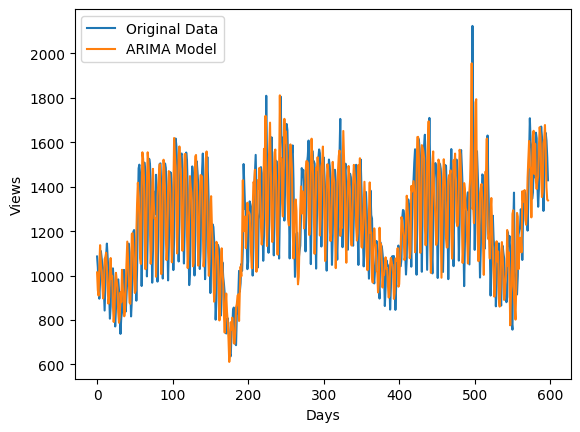

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

params = {'en': [4, 1, 0], 'ja': [7, 1, 1], 'de': [7, 1, 1], 'na': [4, 1, 0], 'fr': [4, 1, 0], 'zh': [7, 1, 1], 'ru': [4, 1, 0], 'es': [7, 1, 1]}

for key in sums:
    data = np.array(sums[key])
    arima = ARIMA(data, order=params[key])
    result = arima.fit()
    pred = result.predict(start=2, end=599, type='levels')
    x = [i for i in range(600)]
    
    # plt.plot(x[2:len(data)], data, label='Data')
    # plt.plot(x[2:], pred, label='ARIMA Model')
    # plt.xlabel('Days')
    # plt.ylabel('Views')
    # plt.legend()
    # plt.show()

    min_length = min(len(data), len(pred))
    data = data[:min_length]
    pred = pred[:min_length]

    # Plot original data and ARIMA model predictions
    plt.plot(data, label='Original Data')
    plt.plot(pred, label='ARIMA Model')

    # Other plotting configurations (labels, legend, etc.)
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()

In [32]:
def smape(y_true, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    """
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# Assuming data and pred are numpy arrays
smape_value = smape(data, pred)
print("SMAPE:", smape_value)

SMAPE: 15.055241229275715


Use the predictions of these models as one of the inputs to our ensemble model

Create another LSTM model for ensemble

In [28]:
train_data2.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,lang
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0,zh
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0,zh
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0,zh


Training LSTM models for top pages of all the languages as a demo

In [29]:
train_data2 = train_data2.drop('Page',axis = 1)
train_data2.shape

(145063, 804)

In [36]:
#Packages for pre processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

 # Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [39]:
# Iterate over the data
for key in sums:
    row = [0] * sums[key].shape[0]
    for i in range(sums[key].shape[0]):
        row[i] = sums[key][i]

    # Using Data From Random Row for Training and Testing
    X = row[0:802]
    y = row[1:803]

    # Convert lists to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    # Reshape X for LSTM input
    X = X.reshape(-1, 1)

    # Split the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Feature Scaling
    sc = MinMaxScaler()
    X_train = sc.fit_transform(X_train)
    y_train = sc.fit_transform(y_train)

    # Reshape X_train for LSTM input
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Initialising the RNN
    regressor = Sequential()

    # Adding the input layer and the LSTM layer
    regressor.add(LSTM(units=8, activation='relu', input_shape=(X_train.shape[1], 1)))

    # Adding the output layer
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, batch_size=10, epochs=100, verbose=0)

    # Getting the predicted Web View
    inputs = sc.transform(X_test)
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
    y_pred = regressor.predict(inputs)
    y_pred = sc.inverse_transform(y_pred)

    # Visualising Result
    plt.plot(y_test, color='red', label='Real Web View')
    plt.plot(y_pred, color='blue', label='Predicted Web View')
    plt.title('Web View Forecasting')
    plt.xlabel('Number of Days from Start')
    plt.ylabel('Web View')
    plt.legend()
    plt.show()


ValueError: Expected 2D array, got 1D array instead:
array=[4042.94429235 4196.497926   3602.90741663 4841.07856313 4230.44744483
 4485.33719097 3959.63451966 8381.57333665 4305.78222997 4005.61539738
 3642.74535424 5514.93686743 3477.97610752 5456.78422101 4704.44902107
 4447.17815663 7790.8892069  3587.05836237 4108.39733698 3752.94661523
 4102.63646922 4545.32068193 4229.85432222 5834.56172225 4124.4883856
 4659.80089597 3956.76962004 3660.94064211 4384.54106521 7688.75111996
 3333.58428737 5660.42458935 3574.02704496 4398.30247221 4302.72722748
 3755.70619711 3733.77708644 4089.90903435 3977.87373486 5010.90401526
 3489.68363199 4409.07064045 5407.86029534 4931.91811847 3425.96329019
 5029.32437365 3230.39920358 3917.42811515 4768.78359881 3668.12497926
 4928.90173386 3800.81512361 3455.5288286  4470.84374481 4111.42197611
 3437.87108014 4310.57960013 7874.74182844 4216.42633151 5190.77210884
 4643.18914883 3819.97731044 4867.67633151 3611.67164427 5431.38721586
 4186.92413307 4097.68707483 4558.06093413 4888.3473121  3300.75178364
 4224.58598805 4332.81553841 4112.52339472 4780.85805542 5341.82495437
 4888.09946906 4213.06230297 3777.37398374 4214.7379708  3918.25294508
 4206.07209225 4138.69474863 4014.89891322 3511.3846441  4804.43023063
 4565.779036   5076.80479509 3582.73436204 3906.21594491 4352.82603285
 4893.5138958  3482.8576821  4818.15057242 4229.87585034 3502.511407
 3714.78127593 3940.01273436 3951.31176373 5860.22755932 3499.12257342
 3718.82221669 5930.4846524  4549.36382114 4796.24933632 4028.04641613
 6072.25564128 4098.32400033 3126.37734362 3780.78940601 4701.04803385
 4309.8524971  4179.8769703  4596.85618882 4398.77555168 3522.22660528
 4573.513481   3821.43259499 4743.79289033 5976.18894143 4645.42027543
 4139.57731873 4066.18653559 3589.97295504 3424.71635971 5060.06674133
 3493.78965489 4408.28252033 3575.52003484 3510.07798241 4022.00701012
 4227.52244068 6357.68657707 4655.94715447 5007.11216194 4484.20379127
 4026.65044798 4004.41654223 4863.6539323  3323.24261656 3298.48452796
 4284.68300979 4174.93164095 3689.16392899 4526.94093247 5125.38530778
 4026.56918865 8083.06632653 4508.60759914 5127.91641779 3851.95511863
 3349.46349759 3720.3981251  5243.94707151 4368.84685582 4699.35237266
 5429.85370002 3868.05255517 3339.33403849 3752.75049776 3488.53724905
 3384.75190808 4466.36357226 3902.80682761 3919.82906089 4770.95097063
 3847.46623527 5008.43632819 5164.24717936 4494.32864609 5656.19255019
 3831.07968309 4075.53102704 3937.78446989 3517.45939107 4160.15384934
 3489.85390742 3999.23336652 4273.14123942 5064.70258835 2983.22809856
 4258.99664012 7890.3529119  4602.92894475 3441.56653393 4394.37141198
 3340.32557657 3786.94777667 3494.01426912 3181.30632985 4683.54571097
 3292.8943919  3818.59490626 5396.31367181 4401.29230961 3242.476149
 4502.23120956 3635.71100879 3330.27609092 6510.97079808 3793.06425253
 4307.29222665 3803.03758089 4196.58573917 3732.723038   3501.01136552
 4977.3782147  4457.5128588  8031.4861042  4540.71835075 5393.88431226
 3831.49328024 3580.4010287  3086.85195786 4380.89140534 4470.68860959
 4027.93906587 5804.14447486 5022.76418616 5007.17541895 4039.60631326
 3588.47378464 3915.25033184 3813.83441181 3817.96528123 3499.79251701
 3645.76642608 4109.80674465 3372.725112   3664.6197113  4461.69566119
 4069.82868757 4722.40982247 4598.95719263 4230.8719927  6017.90090426
 4610.89518002 7531.71403683 4257.03596317 3340.00240584 6053.25315248
 3413.02356064 3684.85635474 4566.96718931 4965.39493114 4693.5265472
 4176.25875228 4769.81636801 3964.70922515 3718.38995354 4000.37253194
 4033.64600962 4668.82727725 6245.12750954 3849.73602124 4103.04401029
 4937.74323876 4285.93724075 4743.22457276 4502.93425419 3846.3659781
 3643.52306288 3664.71515679 5190.1188817  4347.53650241 3602.05292849
 5140.46337315 4060.96217023 3495.32453957 3340.32599137 3456.93848515
 5133.13136718 4708.29649909 4294.54056745 4407.84295669 6098.17533599
 3898.87900282 3616.65107018 3114.98249544 3563.02658868 4938.91757923
 4559.13895802 3441.90853659 3893.42537747 3600.68267795 4683.31429401
 5476.52351916 3226.02132072 4325.02949228 4284.31259333 4003.83354073
 3423.18118467 3335.30628837 6193.13165754 3879.17102207 5061.66994359
 5552.83565621 4532.06981085 8171.6097561  3398.14115646 3558.81288369
 4830.78770533 3750.09785134 4609.99535424 4103.04517173 4532.01372988
 4932.44018583 6325.68313423 3539.80438029 3968.13721586 4147.64264974
 3544.51460096 5288.32076489 5338.68271943 4509.57516177 5498.53778829
 3715.08349925 3916.70997179 3672.92815663 3175.76439356 3617.94284055
 5346.32234113 4402.47332836 3369.42915215 3677.5006222  3812.06479177
 4818.91525635 4239.66820143 3581.94881367 3719.1537249  4021.29778497
 4462.05413141 4196.47042476 3992.34610918 4519.06931309 3909.39866434
 3830.9892152  3504.76207068 3948.24630828 3690.62651402 3939.37381782
 4207.82445661 3522.24386096 3747.79371993 3436.14866434 4188.16803551
 3397.0304878  3086.77119628 4639.4977186  6352.03990377 4585.02082296
 7312.766592   4394.68620375 3899.00688568 7578.94561971 5201.78301809
 5520.06699021 4971.83175709 3885.016592   4288.56309109 4491.97150324
 4471.37921022 4997.99124772 3884.96080139 4203.47208396 3888.34113157
 4146.36792766 3099.10817986 4109.78782977 3387.26260992 3405.35378298
 4595.96515679 3798.53397213 3585.65824623 4372.41836735 4609.53841049
 3824.20968143 4261.05122781 3963.7560146  3834.6439771  4939.90339306
 4737.76854156 5200.24423428 3644.17305459 4384.70001659 5386.28185665
 4540.75190808 4839.25244732 3885.35191638 4575.65604778 4364.93632819
 3523.63389746 4946.18437863 4822.5006222  4673.83134229 5022.37045794
 4048.7234528  4677.02704496 3643.56321553 3982.40073834 3934.12153642
 3992.79645761 4878.56333997 4408.79102373 5385.58188153 5188.71225319
 3786.40949063 3636.90422266 3717.08743985 3520.99207732 4999.01874896
 4456.17458935 8306.66343123 5097.42168575 3544.27538576 3954.94723743
 4068.5952381  4011.7361042  4305.01605276 3921.68035507 4844.46976108
 3764.08449477 4055.35303634 4034.08967977 4555.69296499 3776.67637299
 4774.42052431 4471.47030032 4341.1427327  3285.8846441  3429.31877385
 4301.17069023 3257.56806869 3725.82474697 3267.47142028 3761.62439854
 4228.09200265 3832.41766219 3437.64518002 3361.64136386 3599.89078314
 3320.01418616 3520.8618301  7341.1333997  5292.44727891 4363.95810519
 3743.95084619 4983.42492119 4072.81769537 5358.27389248 3662.94358719
 4112.74469056 3978.8612079  3346.97498756 3786.40550854 5238.54359549
 5081.28011448 4471.05143521 4544.22432388 4587.36033682 4568.16139871
 4863.00240584 4403.64804214 7572.94553675 4155.63601294 4702.04550357
 4260.68761407 6564.87726066 4389.28144185 3828.70412311 3158.57619877
 3545.91264311 3808.49925336 4937.07283889 4404.6514435  4947.63124274
 4164.49950224 4797.98253692 4035.64675626 4108.11693214 4155.48573088
 3815.62796582 3355.3802887  3585.06939605 4045.41915547 4281.3446159
 3469.87958354 4136.50157624 5487.29197777 4737.55653725 6845.45665339
 3483.03388917 3657.09150489 6452.18587191 3765.09349593 4214.80064709
 3230.23166584 4075.20308611 3938.54181185 3491.12419114 4255.45109507
 3472.51397876 4079.36108346 7989.13924838 3939.37568442 3673.42898623
 4733.91430231 5779.04226813 3681.51530612 3190.37850506 3503.13928986
 3283.13592998 4153.01572092 5161.46590343 4862.76037    4327.79554505
 4281.23585532 4530.70922515 3399.19893811 5770.37166086 6040.68072839
 3631.55496101 3964.02534428 3735.29396881 3775.981334   4984.43923179
 3764.30736685 3848.76227808 3576.82109673 4127.2381782  3747.05338477
 4518.6161855  5799.54085781 3627.2456446  3375.93753111 3976.03708313
 3503.25920856 5311.25900116 4543.43583043 3702.5263398  3903.96461755
 3597.85440518 5491.82047453 4854.2369338  3755.94267463 3971.39692218
 8053.13182346 4949.61958686 4947.5232288  3451.83851833 5385.51816824
 3510.36033682 4903.04965157 3322.44972623 3517.05429733 4140.97125436
 3765.02140368 3170.17840551 4496.00717604 3842.12195122 5468.25929152
 4076.13522482].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Create an ensemble of LSTM and ARIMA

In [ ]:
# Generate predictions from ARIMA model
arima_predictions = result.predict(start=550, end=799, type='levels')

# Generate predictions from LSTM model
lstm_predictions = regressor.predict(X_test)

# Combine predictions using averaging
ensemble_predictions = (arima_predictions + lstm_predictions.flatten()) / 2

# Visualize ensemble predictions
plt.plot(y_test, color='red', label='Real Web View')
plt.plot(ensemble_predictions, color='blue', label='Ensemble Predicted Web View')
plt.title('Web View Forecasting (Ensemble)')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()